<a href="https://colab.research.google.com/github/ashishk121/Weighted-Max-Cut/blob/main/Weighted_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An outline of the notebook:
1. Statement of problem
2. Setting up the Classical Hamiltonain
3. QAOA solution
4. QUBO formulation and check
5. Solution on Classic simulated Annealer devices and comparisons 

**1. Statement of problem**

The MaxCut problem is a well-known optimization problem in which the nodes of a given undirected graph have to be divided in two sets (often referred as the set of “white” and “black” nodes) such that the number of edges connecting a white node with a black node are maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be useful (for an explanation of the QAOA algorithm you can read this [blogpost](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained)).

At this [link](https://lucaman99.github.io/new_blog/2020/mar16.html)
 you can find an explicit implementation of the QAOA algorithm to solve the MaxCut problem for the simpler case of an unweighted graph. We ask you to generalize the above code to include also the solution for the case of weighted graphs. You can use the same code or you can also do an alternative implementation using, for example, qiskit. The important point is that you do not make use of any built-in QAOA functionalities.




**2. Set-Up and Classical problem**


**Definitions:**

We are given an undirected graph $G=(V,E)$ with $n$ edges. This information can be alternatively encoded in the adjacency matrix $a_{ij}$ which is defined such that $a_{ij}=1$ if there an edge between the vertices $i,j \in V$ and $0$ otherwise. Each non-zero $a_{ij}$ has an associated weight associated with it $w_{ij}$ which we take to be positive.



**Let us define a weighted Adjacency matrix** $A_{ij}$ as the adjacency matrix, but with weights $w_{ij}$ as the entry wherever $a_{ij}=1$ and $0$ elsewhere. 

**Finding the objective function**

To an arbitrary vertex $i$ we can assign a black or white colouring by associating to it a binary variable $x_i$. The problem of dividing $V$ into 2 sets is then the same as assigning all the $x_i$ the value $0$ or $1$ provided this assignment achieves the weighted maximum of cut edges connecting a white node with a black node.

Let's look at the favourable and unfavourable situtations in detail in order to write down the correct objective:

**Favourable**:

 $A_{ij}=\text{large number}$ And $(x_i-x_j)^2=1$ (an edge strongly connects $i,j$ and it is cut ie. $i,j$ are in different sets)

Squaring the difference is important because we do not care if $\{x_i=1,x_j=0\}$ or  $\{x_i=0,x_j=1\}$

**Un-Favourable**:

$A_{ij}=\text{small number}$ And $(x_i-x_j)^2=1$ (an edge weakly connects  $i,j$  but there is a cut )

$A_{ij}=\text{large number}$ And $(x_i-x_j)^2=0$ (an edge strongly connects  $i,j$  but there is no cut )

**Do not care**:

$A_{ij}=0$ and $(x_i-x_j)^2=0$ (an edge does not connect  $i,j$  and there is no cut )

So we need to go through all possible assingments of $x_i$ and $x_j$ maximise while maximizing the following objective:



**Objective to be Maximized for Weighted Cuts**=$\sum_{i,j=1}^{n} A_{ij} (x_i-x_j)^2 $



The weighted max cut is a special case of these considerations and it is also clear that the objective function for the unweighted problem is
**Objective to be Maximized for Un-Weighted Cuts**=$\sum_{i,j=1}^{n} a_{ij} (x_i-x_j)^2 $


We can rewrite the above objective by :
1. changing variables which take values $-1,1$ instead of $0,1$ via the map $f(x)=1-2x$ 
2. sum over only indices which have an edge connecting them 
3. minimizing by multiplying by an overall minus.
This gives us the generalization of cost function in [Jack Ceroni](https://lucaman99.github.io/new_blog/2020/mar16.html)

**Objective to be Minimized for Weighted Max Cuts** = $\sum_{a,b} w_{ab} (c_a c_b-1) $ where $(a,b)\in E$ 



In [313]:

try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import math
import random
from scipy.optimize import minimize  
from collections import defaultdict 


We define Edges which contain information of the two edges it connects and the associated weight 


In [314]:
# We take this weighted adjacency matrix as our example
num=5;
A=np.array([[0,1,1,0,0],[1,0,0,10,0],[1,0,0,1,1],[0,10,1,0,1],[0,0,1,1,0]])

# Edge is labeled by the two vertices it connects and the associated weight
class Edge:
    def __init__(self, start_node, end_node, weight):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight 

# Go from A to edges
set_edges=[];
for i in range(0,num):
  for j in range(0,num):
    if (A[i,j]!=0) and (j>i):
      set_edges.append(Edge(i, j, A[i,j])) 

3. **QAOA solution**

**Quantum Problem**

We can promote the classical variables $c_a$ to quantum variables $Z_a$ and the quantum Hamiltonian that we want to minimize is: 

$H_C=  \sum_{a,b} w_{ab} (Z_a Z_b- \mathbb{I})$ where $(a,b)\in E$


The Identity gives an overall constant shift, so we can drop it 

$$H_C=  \sum_{a,b} w_{ab} Z_a Z_b$$ where $(a,b)\in E$


Here $Z_a$ is the operator $\sigma_z$ applied at the vertex $a$ which is associated with qubit $a$.
If we find the ground state of this Hamiltonian and measure its expectation value in the ground state in the $Z$ basis, we are done. The measurement would give us the classical variables $c_a$ which we can convert back to $x_a$. 

We need to find the ground state and the  ansatz for the ground state according to QAOA algorithm is the state:

$$ |\psi(\gamma,\beta)> = e^{- i \beta_p H_M} e^{-i \gamma_p H_C} ... e^{- i \beta_1 H_M}e^{- i \gamma_1 H_C} (|+> \otimes...|+> ) $$

In our circuit, depth is denoted by p, n is denoted by num and the mixer Hamiltonian is $H_M= \sum_{i=1}^n X_i$


$H_M$ chosen this way guarantees that $[H_M,H_C]\neq 0$ since for $i=a$ or $b$, $Z_a$ and $X_a$ act on the same site and do not commute.

This ensures that we are not stuck in the subspace where $[H_M,H_C]= 0$ in our variational search for the ground state. 

**The code below is heavily influnced by the great article by [Jack Ceroni](https://lucaman99.github.io/new_blog/2020/mar16.html)**

In [315]:
# Defines the list of qubits
num = 5
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

# Defines the initialization of state psi

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [316]:
def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZ(qubits[i.start_node], qubits[i.end_node])**(-1*(gamma)*i.weight) 
        
# Defines the mixer unitary

def mixer_unitary(qubits, beta):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*beta).on(qubits[i])

In [317]:
# Executes the circuit

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    beta = [params[1], params[3], params[5],  params[7]]

# Put together initialization, cost and mixer hamiltonians and finally read out measurements 
    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, beta[i]))
    circuit.append(cirq.measure(*qubits, key='x'))


    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

In [318]:
# we can now convert our measurements in c_a variables to x_a variables which are binary
def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += 0.5*( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost


**Classical Optimization** 


We now do the classical variational part of tuning all possible $\{\beta_i,\gamma_i\}$ in order to get as close to the ground state as possible.  This is tried via two different optimizers with random initialization. It seems like this process is highly dependant on the initialization. 



In [ ]:
init =[float(random.randint(-100, 100))/float(200) for i in range(0, 2*depth)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':1000})
print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)
# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)

<BarContainer object of 32 artists>

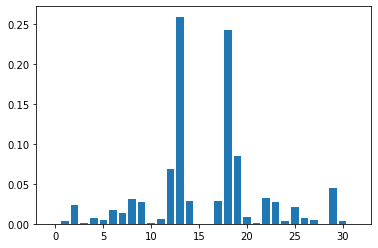

In [326]:
plt.bar(x, y)

In [149]:
np.argmax(y)

13

**We  find y=13 and y=18 as very clear peaks which correspond to the following assignment of $$x=\{0,1,1,0,0\}$$ and $$x=\{1,0,0,1,0\}$$**


Note: Actually, after running this many times, it seems like getting such a clear plot as above is highly dependant on initial conditions and is deceptive.

In [ ]:
init =[float(random.randint(-100, 100))/float(200) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="Nelder-Mead", options={'maxiter':100})
print(out)

optimal_params = out['x']

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)


fig=plt.bar(x, y)

<BarContainer object of 32 artists>

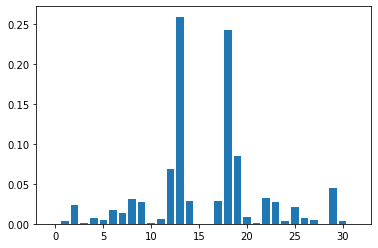

In [328]:
plt.bar(x, y)

In [176]:
bin(13)[2::],bin(18)[2::]


('1101', '10010')

**Changing the classical optimizer to Nelder-Mead, we again find y=13 and y=18 which corresponds to the following assignment of $$x=\{0,1,1,0,0\}$$ and $$x=\{1,0,0,1,0\}$$**





**4. QUBO Formulation**

In order to check these results we reformulate the max-cut problem as a QUBO (Quandratic Unconstrained Binary Optimization) problem. This has the following advantages:
1. There are many classical QUBO solvers, which we can use to check the validity of our results.
2. Quantum Annealer devices such as D-Wave, can solve QUBO problems, so this will let us compare results between these 2 different types of quantum algorithms to solve the weighted max cut problem.


A QUBO problem is of the following type, find the binary variables $x_i$ which minimize the following objective:

$$\sum_{i,j=1}^n x_i Q_{ij} x_j$$

where Q is a real symmetric matrix. 

This is very similar to our original formulation of the problem: Find the x which minimizes the following objective: 

$$ \sum_{i,j=1}^n - A_{ij}(x_i- x_j)^2  $$

Below, we compute the matrix Q given a matrix A. 
In order to compare with earlier results, we use the matrix A corresponding to the previous problem.

Rearranging and summing over redundant indices gives





In [173]:
A=np.array([[0,1,1,0,0],[1,0,0,10,0],[1,0,0,1,1],[0,10,1,0,1],[0,0,1,1,0]])
B=np.array(np.ones((num,num)))
Q=2*A - np.diag(np.diagonal(np.matmul(A,B)))


q0=defaultdict(int)
for u in range(0,num):
    for v in range(0,num):
        q0[(u,v)]= Q[u,v];

In [127]:
import dimod

In [174]:
sampler = dimod.ExactSolver()
response=sampler.sample_qubo(q0)
print(response)

    0  1  2  3  4 energy num_oc.
4   0  1  1  0  0  -14.0       1
14  1  0  0  1  0  -14.0       1
28  0  1  0  0  1  -13.0       1
15  0  0  0  1  0  -12.0       1
17  1  0  0  1  1  -12.0       1
27  0  1  1  0  1  -12.0       1
3   0  1  0  0  0  -11.0       1
8   0  0  1  1  0  -11.0       1
29  1  1  0  0  1  -11.0       1
16  0  0  0  1  1  -10.0       1
2   1  1  0  0  0   -9.0       1
9   1  0  1  1  0   -9.0       1
5   1  1  1  0  0   -8.0       1
26  1  1  1  0  1   -6.0       1
23  0  0  1  1  1   -5.0       1
30  1  0  0  0  1   -4.0       1
7   0  0  1  0  0   -3.0       1
22  1  0  1  1  1   -3.0       1
1   1  0  0  0  0   -2.0       1
31  0  0  0  0  1   -2.0       1
6   1  0  1  0  0   -1.0       1
24  0  0  1  0  1   -1.0       1
0   0  0  0  0  0    0.0       1
25  1  0  1  0  1    1.0       1
12  0  1  0  1  0   17.0       1
11  0  1  1  1  0   18.0       1
13  1  1  0  1  0   19.0       1
19  0  1  0  1  1   19.0       1
18  1  1  0  1  1   21.0       1
10  1  1  

**The exact solver tells us that the  correct solution is indeed $x=\{0,1,1,0,0\}$** and **$x=\{1,0,0,1,0\}$**

We can also run this on the classical annealing simulator which let's us acess much larger n, where it is impossible for the exact solver to work



In [177]:
numruns=100
sampler = dimod.SimulatedAnnealingSampler()
response=sampler.sample_qubo(q0)
print(response)

   0  1  2  3  4 energy num_oc.
0  0  1  1  0  0  -14.0       1
1  0  1  1  0  0  -14.0       1
2  0  1  1  0  0  -14.0       1
4  1  0  0  1  0  -14.0       1
5  1  0  0  1  0  -14.0       1
6  0  1  1  0  0  -14.0       1
7  0  1  1  0  0  -14.0       1
8  0  1  1  0  0  -14.0       1
9  0  1  1  0  0  -14.0       1
3  0  1  0  0  1  -13.0       1
['BINARY', 10 rows, 10 samples, 5 variables]


**Simullated annealing can find both ground states**

**We can try the problem out on a larger sized graph to see how things work, code below repeats**

In [210]:
num=12;
A = np.random.randint(0,10,size=(num,num))
A= (A + A.T)
np.fill_diagonal(A, 0)

B=np.array(np.ones((num,num)))
Q=2*A - np.diag(np.diagonal(np.matmul(A,B)))

q0=defaultdict(int)
for u in range(0,num):
    for v in range(0,num):
        q0[(u,v)]= Q[u,v];

set_edges=[];
for i in range(0,num):
  for j in range(0,num):
    if (A[i,j]!=0) and (j>i):
      set_edges.append(Edge(i, j, A[i,j])) 

In [211]:
A

array([[ 0,  1, 10,  5, 12, 10,  6, 12,  7, 15, 14,  7],
       [ 1,  0, 12,  6, 10, 15,  6,  9,  0,  9, 11, 14],
       [10, 12,  0, 13,  7,  9,  5,  9,  7,  6, 11,  8],
       [ 5,  6, 13,  0,  9,  9,  8, 12,  6, 14, 12, 13],
       [12, 10,  7,  9,  0, 10, 10, 13,  6, 13, 10, 10],
       [10, 15,  9,  9, 10,  0,  6, 11,  4,  8,  6, 12],
       [ 6,  6,  5,  8, 10,  6,  0,  7, 11,  9,  5, 16],
       [12,  9,  9, 12, 13, 11,  7,  0,  4,  5, 10, 14],
       [ 7,  0,  7,  6,  6,  4, 11,  4,  0, 11, 11,  7],
       [15,  9,  6, 14, 13,  8,  9,  5, 11,  0, 10,  8],
       [14, 11, 11, 12, 10,  6,  5, 10, 11, 10,  0, 15],
       [ 7, 14,  8, 13, 10, 12, 16, 14,  7,  8, 15,  0]])

In [ ]:
# Defines the list of qubits
depth = 4
rep = 10000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

# Defines the initialization of state psi

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)
def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZ(qubits[i.start_node], qubits[i.end_node])**(-1*(gamma)*i.weight) 
        
# Defines the mixer unitary

def mixer_unitary(qubits, beta):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*beta).on(qubits[i])      

# Executes the circuit

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    beta = [params[1], params[3], params[5],  params[7]]

# Put together initialization, cost and mixer hamiltonians and finally read out measurements 
    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, beta[i]))
    circuit.append(cirq.measure(*qubits, key='x'))


    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res       

# we can now convert our measurements in c_a variables to x_a variables which are binary
def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += 0.5*( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost

init =[float(random.randint(-100, 100))/float(200) for i in range(0, 2*depth)]
out = minimize(cost_function, x0=init, method="Nelder-Mead", options={'maxiter':100})
print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)
# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)

<BarContainer object of 4096 artists>

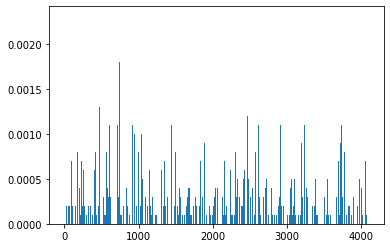

In [311]:
plt.bar(x, y)

In [309]:
np.argmax(y)

3485

In [310]:
bin(3485)[2::]

'110110011101'

Our QAOA solver suggests that there 1 solution which is $$\{1,1,0,1,1,0,0,1,1,1,0,1\}$$

In [215]:
sampler = dimod.ExactSolver()
response=sampler.sample_qubo(q0)

(array([1.348e+03, 1.294e+03, 7.340e+02, 4.230e+02, 1.920e+02, 4.200e+01,
        4.900e+01, 8.000e+00, 5.000e+00, 1.000e+00]),
 array([-273. , -123.5,   26. ,  175.5,  325. ,  474.5,  624. ,  773.5,
         923. , 1072.5, 1222. ]),
 <a list of 10 Patch objects>)

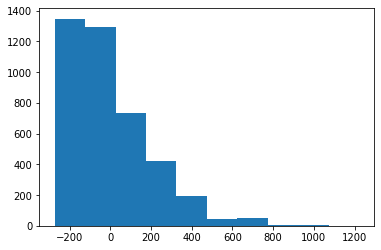

In [245]:
plt.hist(response.data_vectors['energy'])

In [291]:
response.lowest().first.sample

{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0}

The exact solver tells us that there is 1 solution for x which is $$\{1,1,0,1,0,0,0,0,1,0,0,0 \}$$

In [307]:
numruns=10000
sampler = dimod.SimulatedAnnealingSampler()
response=sampler.sample_qubo(q0)
print(response)

   0  1  2  3  4  5  6  7  8  9 10 11 energy num_oc.
8  1  1  0  1  0  0  0  0  1  0  0  0 -273.0       1
0  0  0  1  0  0  0  0  0  0  1  0  1 -241.0       1
1  0  0  1  0  0  0  0  0  0  1  0  1 -241.0       1
3  0  0  1  0  0  0  0  0  0  1  0  1 -241.0       1
4  0  0  1  0  0  0  0  0  0  1  0  1 -241.0       1
6  0  0  1  0  0  0  0  0  0  1  0  1 -241.0       1
5  0  0  0  0  0  1  1  0  0  0  1  0 -236.0       1
7  0  0  0  0  0  1  1  0  0  1  1  0 -236.0       1
9  0  0  0  0  0  1  1  0  0  1  1  0 -236.0       1
2  0  0  0  0  0  0  1  1  0  1  1  0 -234.0       1
['BINARY', 10 rows, 10 samples, 12 variables]


**The simulated annealer can find the exact ground state is $$x=\{1,1,0,1,0,0,0,0,1,0,0,0 \}$$**

So our QAOA does not seem to work perfectly for randomly created n=12 graphs, but the simulated annealer works perfectly. 


We can quantify far away we are from the correct answer by looking at the  binary hamming distance between $$x_{QAOA}=\{1,1,0,1,1,0,0,1,1,1,0,1\}$$ and $$x_{exact}=\{1,1,0,1,0,0,0,0,1,0,0,0 \}$$
which we calculate to be $d_b=4$  

Examining the above two strings, we can see that we got an approximate answer that was not too wrong. I think the algorithm can be improved by:

1. Carefully tuning hyperparameters such as the random initialization of $\alpha_i,\beta_i$ and depth
2. Specializing to physically motivated Hamiltonians such as the SK model, may also point us in the correct direction to develop  heuristics for point 1.   

